In [1]:
import tensorflow as tf
from PIL import ImageOps
import keras
import numpy as np
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io
img_size = (256, 256)
num_classes = 2
batch_size = 32
def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""

    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf_image.convert_image_dtype(target_img, "uint8")

        # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
        # target_img -= 1
        return input_img, target_img

    # For faster debugging, limit the size of data
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)
model = tf.keras.models.load_model('oxford_segmentation.tf')

2024-03-13 19:07:00.343266: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-13 19:07:01.279781: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-03-13 19:07:02.621701: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-13 19:07:02.819093: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-13 19:07:02.819147: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_exec

In [2]:
import os
import re
import tools.cv2_visualise as cv2_visualizer
input_img_paths = sorted([os.path.join("data/test_tiles", fname) for fname in os.listdir("data/test_tiles")])
target_img_paths = sorted([os.path.join("data/test_mask_tiles", fname) for fname in os.listdir("data/test_mask_tiles")])
input_img_paths = sorted(input_img_paths, key=lambda x: [int(i) if i.isdigit() else i for i in re.split('(\d+)', x)])
target_img_paths = sorted(target_img_paths, key=lambda x: [int(i) if i.isdigit() else i for i in re.split('(\d+)', x)])


In [3]:
import os
def find_images_with_prefix(base_path, prefix):
    image_set = set()
    for fname in os.listdir(base_path):
        if fname.startswith(prefix):
            image_set.add(os.path.join(base_path, fname))
    sorted_images = sorted(image_set, key=lambda x: [int(i) if i.isdigit() else i for i in re.split('(\d+)', x)])
    return sorted_images
    
base_path = "data/test-tiles"
base_mask_path = "data/test_mask-tiles"
prefix_45 = "45."
prefix_79 = "79."
prefix_43 = "43."
prefix_91 = "91."
input_img_paths_45 = find_images_with_prefix(base_path, prefix_45)
target_img_paths_45 = find_images_with_prefix(base_mask_path, prefix_45)
input_img_paths_79 = find_images_with_prefix(base_path, prefix_79)
target_img_paths_79 = find_images_with_prefix(base_mask_path, prefix_79)
input_img_paths_43 = find_images_with_prefix(base_path, prefix_43)
target_img_paths_43 = find_images_with_prefix(base_mask_path, prefix_43)
input_img_paths_91 = find_images_with_prefix(base_path, prefix_91)
target_img_paths_91 = find_images_with_prefix(base_mask_path, prefix_91)

In [5]:
test_dataset_45 = get_dataset(
    16, img_size, input_img_paths_45,target_img_paths_45
)

test_preds_45 = model.predict(test_dataset_45)

test_dataset_79 = get_dataset(
    16, img_size, input_img_paths_79,target_img_paths_79
)

test_preds_79 = model.predict(test_dataset_79)

test_dataset_43 = get_dataset(
    16, img_size, input_img_paths_43, target_img_paths_43
)

test_preds_43 = model.predict(test_dataset_43)

test_dataset_91 = get_dataset(
    16, img_size, input_img_paths_91,target_img_paths_91
)

test_preds_91 = model.predict(test_dataset_91)

2024-03-13 19:07:35.657684: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8800


46/46 [==============================] - 4s 98ms/step


In [7]:
test_pred_list = []
def generate_pred_list(i):
    mask = np.argmax(test_preds_45[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    test_pred_list.append(img)

for i in range(len(test_preds_45)):
    generate_pred_list(i)

In [8]:
gd_rect_45 = cv2_visualizer.overlay_gd_and_rectangles(mask_dir_path="data/source-masks-test/", file_path="data/visualized_masks/tile.csv", image_number=45, dir_path="data/source-images-test/", save_path="data/cv2-test/rectangles_" ,mask_save_path="data/cv2-test/merged_rectangles_with_mask_" )

In [9]:
pred_45 = cv2_visualizer.merge_prediction_csv("data/visualized_masks/tile.csv", test_pred_list, input_img_paths_45, "data/source-images-test/", 45, "data/cv2-test/prediction_mask_", "data/source-images-test/")

In [10]:
final_mask_45 = cv2_visualizer.final_mask_overlay("data/cv2-test/prediction_mask_",  45,   "data/cv2-test/merged_rectangles_with_mask_", "data/cv2-test/final_mask_")

In [11]:
tiles = cv2_visualizer.divide_image_into_tiles("data/cv2-test/final_mask_45.png")

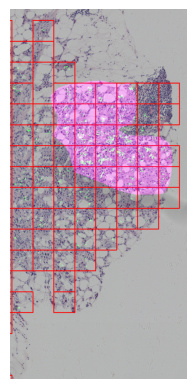

In [12]:
cv2_visualizer.display_tile(tiles, 10)